# Multi-Agents

## Goal

We'll combine our previous themes, along with some new one, into a multi-agent researcher:

1) `Human In The Loop` --  A human will provide an overall topic to research. We will generate a set of AI analysts that research specific sub-topics related to the provided topic. We'll use human-in-the-loop to review and refine these sub-topics before the research phase.

2) `Sub-graphs` -- Each analyst will interview an expert on their sub-topic of focus. These interviews will be encapsulated in sub-graphs, with their own internal `messages` state, and may be multi-turn as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.

3) `Parallelization` -- Each expert will use different knowledge gathering tools in parallel, such as search and retrieval, to answer questions from the analyst.
 
4) `Map-reduce` -- The interviews will be done in parallel using map-reduce, resulting in a multi-agent workflow. Each analyst will distill the interview into a section of the final report. These sections will be added to an overall report. A final refinement phase will be used to add an introduction and conclusion.

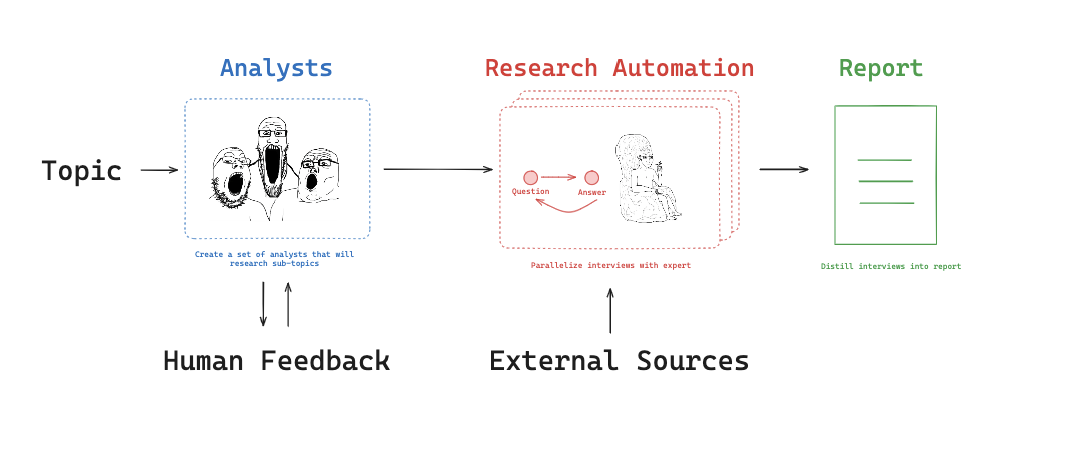

## LLM

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

## State and Schemas 

In [153]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict

from langchain_core.pydantic_v1 import BaseModel, Field

from langgraph.channels import Topic

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add] 
    final_report: str
    analyst_feedback: str 
    editor_feedback: str 

class InterviewState(TypedDict):
    topic: str
    max_num_turns = int
    messages: Annotated[List[AnyMessage], add_messages]
    context: Annotated[list, Topic(typ=list, accumulate=True, unique=True)]
    analyst: Analyst
    editor_feedback: str
    interview: str
    sections: list 

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

## Generate Analysts: Human-In-The-Loop

Use HIL to lay out the analyst focus areas.

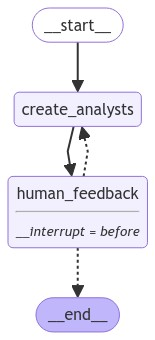

In [111]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def create_analysts(state: ResearchGraphState):
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
    
    instructions = SystemMessage(content=f"""
    
    You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

    1. First, review the research topic:
    
    {topic}
            
    2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
    {human_analyst_feedback}
      
    3. Determine the most interesting themes based upon documents and / or feedback above.
                        
    4. Pick the top {max_analysts} themes.

    5. Assign one analyst to each theme.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # Generate question 
    analysts = structured_llm.invoke([instructions]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: ResearchGraphState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: ResearchGraphState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [113]:
# Input
max_analysts = 3 

topic = '''I want a report focused on the innovations related to the Meta LLlama3.1 work, 
especially on training infrastructue, model architecture, and quantization approaches.'''

thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    print(event.get('analysts',''))


[Analyst(affiliation='OpenAI', name='Dr. Emily Carter', role='Training Infrastructure Specialist', description='Dr. Carter focuses on the development and optimization of large-scale training infrastructures. Her primary concern is to ensure that the infrastructure can handle the computational demands of training advanced models like Meta LLlama3.1 efficiently and cost-effectively.'), Analyst(affiliation='DeepMind', name='Dr. Rajesh Patel', role='Model Architect', description='Dr. Patel is an expert in neural network architectures. He is particularly interested in the innovative aspects of the Meta LLlama3.1 model architecture, including any novel layers, attention mechanisms, or other structural changes that enhance performance.'), Analyst(affiliation='Google Research', name='Dr. Mei Ling', role='Quantization Expert', description='Dr. Ling specializes in model quantization techniques. Her focus is on how Meta LLlama3.1 employs quantization to reduce model size and inference time witho

In [114]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [115]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Ensure the infrastructure analysts focuses on the networking and use of infiniband"}, as_node="human_feedback")

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef642a4-ff51-6ce2-8002-47cced9822c4'}}

In [116]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print("--Updated--")
    print(event.get('analysts',''))

--Updated--
[Analyst(affiliation='TechNet Research', name='Alice_Wong', role='Infrastructure Analyst', description='Alice specializes in the networking aspects of AI training infrastructure, with a particular focus on the use of Infiniband technology to enhance data throughput and reduce latency in distributed training environments.'), Analyst(affiliation='DeepModel Insights', name='Raj_Patel', role='Model Architecture Analyst', description='Raj is an expert in neural network design and optimization. He focuses on the architectural innovations in Meta LLlama3.1, analyzing how changes in model structure contribute to performance improvements and efficiency.'), Analyst(affiliation='QuantTech Solutions', name='Maria_Garcia', role='Quantization Analyst', description="Maria's expertise lies in model quantization techniques. She examines the approaches used in Meta LLlama3.1 to reduce model size and computational requirements while maintaining accuracy.")]


In [117]:
# We now update the state as if we are the human_feedback node with satisfaction
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef642a5-6fc1-616c-8004-c7b62721199b'}}

In [118]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="values"):
    print("--Updated--")
    print(event.get('analysts',''))

In [119]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

## Conduct Interview

### Generate Question

Now, we give the analyst the ability to ask questions.

In [154]:
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 

    Your goal is boil down to interesting and specific insights related to your topic.

    1. Interesting: Insights that people will find surprising or non-obvious.
            
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Here is your topic of focus and set of goals: {analyst.persona}
            
    Begin by introducing yourself using a name that fits your persona, and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.
            
    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")

    # Generate question 
    question = llm.invoke([instructions]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

Let the expert gather information from multiple sources.

Here, let's use a document (of known relevance) and web-search (open-ended search).

In [125]:
# The doc can be from web, PDF, etc and we can use an index 

from langchain_community.document_loaders import WebBaseLoader
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
EXPERT_DOC_CONTEXT = WebBaseLoader(url).load()

In [168]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Load llama3.1 paper (pdf)
loader = PyPDFLoader("../assistant/docs/llama3_1.pdf")
pages = loader.load_and_split()

# Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Full paper, except for references 
all_pages_except_references=pages[:100]

# Index
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references, embedding=embeddings)

# Build retriever
retriever = vectorstore.as_retriever(k=10)

In [127]:
# The web search tool

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

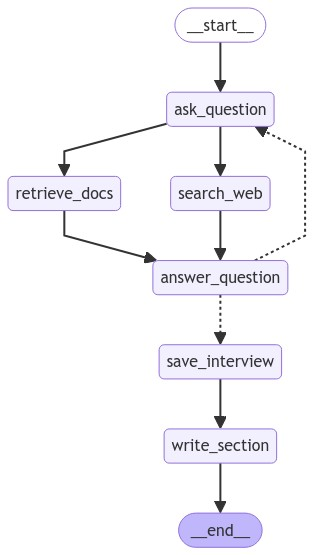

In [170]:
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string

# Search query
instructions = SystemMessage(content=f"""

You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def retrieve_docs(state: InterviewState):
    
    """ Get docs """

    # Enforce structured output
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+messages)
    
    # Retrieve
    docs = retriever.invoke(search_query.search_query)

    # Format
    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"context": [formatted_retrieved_docs]} 

    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in EXPERT_DOC_CONTEXT
        ]
    )
    
    return {"context": [formatted_retrieved_docs]} 

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Get messages
    messages = state['messages']

    # Enforce structured output
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+messages)
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]

    instructions = SystemMessage(content=f"""
    
    You are an expert being interviewed by an analyst who focused on learning this topic: {topic}. 
            
    You goal is to answer a question posed by the interviewer.

    To answer question, use this context:
            
    {context}

    When answering questions, follow these guidelines:
            
    1. Use only the information provided in the context. 
            
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preanble in your citation.""")
   
    # Answer question
    answer = llm.invoke([instructions]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    instructions = SystemMessage(content=f"""You are an expert technical writer. 
            
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: 
    {analyst.description}

    4. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
       
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed""")
   
    # Write section using either the gathered source docs from interview, or the interview itself 
    section = llm.invoke([instructions]+[HumanMessage(content=f"Use this source to write your section: {context}")])
                
    # Append it to state
    return {"sections": section}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("retrieve_docs", retrieve_docs)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "retrieve_docs")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("retrieve_docs", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [171]:
# Pick one analyst
analysts[0]

Analyst(affiliation='TechNet Research', name='Alice_Wong', role='Infrastructure Analyst', description='Alice specializes in the networking aspects of AI training infrastructure, with a particular focus on the use of Infiniband technology to enhance data throughput and reduce latency in distributed training environments.')

In [172]:
from IPython.display import Markdown

# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
initial_state = {"analyst": analysts[0], "messages": messages}
thread = {"configurable": {"thread_id": "1"}}

# Run
interview = interview_graph.invoke(initial_state, thread)
Markdown(interview['sections'].content)

## Enhancing AI Training with Infiniband: Insights from Llama 3

### Summary

In the rapidly evolving field of artificial intelligence (AI), the efficiency and performance of training infrastructure are paramount. Alice, an expert in networking aspects of AI training infrastructure, focuses on leveraging Infiniband technology to enhance data throughput and reduce latency in distributed training environments. This report delves into the novel advancements and insights gathered from the development and deployment of Meta's Llama 3 models, particularly emphasizing the networking strategies employed.

Llama 3 represents a significant leap in AI model development, featuring a dense Transformer with 405 billion parameters and a context window of up to 128K tokens. The model supports multilinguality, coding, reasoning, and tool usage, positioning it as a competitive alternative to leading models like GPT-4. The integration of image, video, and speech capabilities further extends its versatility [1].

One of the most intriguing aspects of Llama 3's development is the networking infrastructure that supports its training. Meta employs a combination of Remote Direct Memory Access over Converged Ethernet (RoCE) and Infiniband technologies to manage the massive data throughput required for training such large models. The RoCE-based AI cluster, comprising 24,000 GPUs connected by a three-layer Clos network, ensures efficient data transfer and minimal latency. This setup is crucial for maintaining high performance and reliability during training [1][2].

The use of Infiniband technology, particularly Nvidia Quantum2 Infiniband fabric, in smaller models within the Llama 3 family highlights its effectiveness in handling complex workloads. Infiniband's ultra-fast processing capabilities and high throughput make it an ideal choice for AI training environments that demand extreme parallelism and large-scale data handling [3].

The combination of RoCE and Infiniband technologies in Llama 3's training infrastructure demonstrates a strategic approach to optimizing network performance. By tuning both network types to provide equivalent performance, Meta ensures that the training workloads are efficiently managed, regardless of the underlying network technology. This hybrid approach not only enhances data throughput but also reduces latency, which is critical for the successful training of large AI models [1][2][3].

In summary, the development of Llama 3 underscores the importance of advanced networking technologies in AI training. The strategic use of RoCE and Infiniband fabrics, along with a robust network topology, enables Meta to achieve high performance and reliability in training their state-of-the-art models. These insights provide valuable lessons for optimizing AI training infrastructure, particularly in leveraging Infiniband technology to enhance data throughput and reduce latency.

### Sources
[1] https://llama.meta.com/  
[2] https://cs.stanford.edu/~keithw/sigcomm2024/sigcomm24-final246-acmpaginated.pdf  
[3] https://www.nvidia.com/en-us/networking/products/infiniband/

## Parallelize Interviews

### Create sub-graphs

First, we encapsulate each interview with a sub-graph.

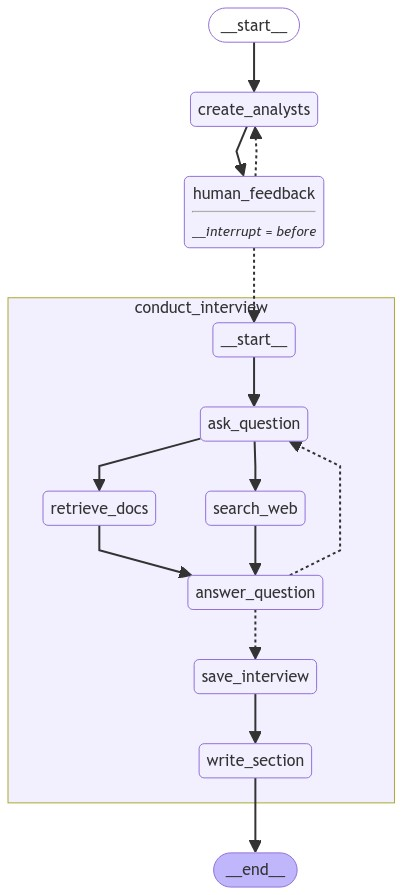

In [173]:
# Build the full graph
builder = StateGraph(ResearchGraphState)

def should_continue(state: ResearchGraphState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return "conduct_interview"

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Parallelze interviews: Map-Reduce

Now, we parallelize the interview.

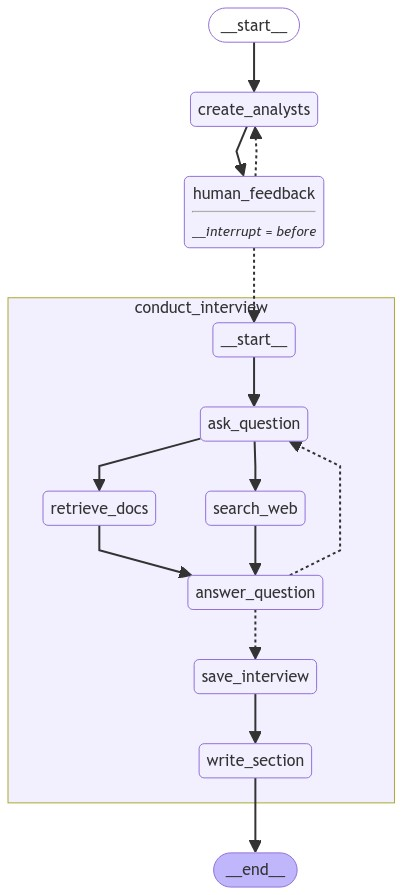

In [166]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise kick off interviews via map-reduce
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Final report writing

Add sections, write intro and conclusion. 